In [1]:
!wget https://storage.googleapis.com/imposing-coyote-328710.appspot.com/trainingdata.zip

--2024-07-22 05:05:57--  https://storage.googleapis.com/imposing-coyote-328710.appspot.com/trainingdata.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.125.207, 172.217.214.207, 74.125.126.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.125.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4155000401 (3.9G) [application/x-zip-compressed]
Saving to: 'trainingdata.zip'

trainingdata.zip    100%[===================>]   3.87G  13.0MB/s    in 4m 59s  

2024-07-22 05:10:57 (13.3 MB/s) - 'trainingdata.zip' saved [4155000401/4155000401]



In [2]:
!unzip trainingdata.zip 'content/trainingdata/data_16/*'

Archive:  trainingdata.zip
   creating: content/trainingdata/data_16/
   creating: content/trainingdata/data_16/train/
  inflating: content/trainingdata/data_16/train/dataset_spec.pb  
   creating: content/trainingdata/data_16/train/15938854272141767756/
   creating: content/trainingdata/data_16/train/15938854272141767756/00000000.shard/
  inflating: content/trainingdata/data_16/train/15938854272141767756/00000000.shard/00000000.snapshot  
 extracting: content/trainingdata/data_16/train/snapshot.metadata  
   creating: content/trainingdata/data_16/test/
  inflating: content/trainingdata/data_16/test/dataset_spec.pb  
   creating: content/trainingdata/data_16/test/8136806561035047138/
   creating: content/trainingdata/data_16/test/8136806561035047138/00000000.shard/
  inflating: content/trainingdata/data_16/test/8136806561035047138/00000000.shard/00000000.snapshot  
 extracting: content/trainingdata/data_16/test/snapshot.metadata  
   creating: content/trainingdata/data_16/val/
   creat

In [3]:
!pip show tensorflow

Name: tensorflow
Version: 2.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /opt/conda/lib/python3.10/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: explainable-ai-sdk, tensorflow-cloud, tensorflow-decision-forests, tensorflow-serving-api, tensorflow-text, tf_keras, witwidget


In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2024-07-22 05:12:26.356760: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-22 05:12:26.356870: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-22 05:12:26.611657: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Num GPUs Available:  2


In [5]:
!pip install remotezip tqdm opencv-python einops
# Install TensorFlow 2.10
#!pip install tensorflow==2.10.0

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 648.0 kB/s eta 0:00:00


In [6]:
!pip install -U tqdm

In [7]:
import tqdm
import random
import pathlib
import itertools
import collections

import cv2
import einops
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.layers import Dropout

## Load and preprocess video data

The hidden cell below defines helper functions to download a slice of data from the UCF-101 dataset, and load it into a `tf.data.Dataset`. You can learn more about the specific preprocessing steps in the [Loading video data tutorial](../load_data/video.ipynb), which walks you through this code in more detail.

The `FrameGenerator` class at the end of the hidden block is the most important utility here. It creates an iterable object that can feed data into the TensorFlow data pipeline. Specifically, this class contains a Python generator that loads the video frames along with its encoded label. The generator (`__call__`) function yields the frame array produced by `frames_from_video_file` and a one-hot encoded vector of the label associated with the set of frames.

In [8]:
#@title

def list_files_per_class(zip_url):
  """
    List the files in each class of the dataset given the zip URL.

    Args:
      zip_url: URL from which the files can be unzipped.

    Return:
      files: List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(URL) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

def get_class(fname):
  """
    Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Return:
      Class that the file belongs to.
  """
  return fname.split('_')[-3]

def get_files_per_class(files):
  """
    Retrieve the files that belong to each class.

    Args:
      files: List of files in the dataset.

    Return:
      Dictionary of class names (key) and files (values).
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

def download_from_zip(zip_url, to_dir, file_names):
  """
    Download the contents of the zip file from the zip URL.

    Args:
      zip_url: Zip URL containing data.
      to_dir: Directory to download data to.
      file_names: Names of files to download.
  """
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file,)

def split_class_lists(files_for_class, count):
  """
    Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.

    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Return:
      split_files: Files belonging to the subset of data.
      remainder: Dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

def download_ufc_101_subset(zip_url, num_classes, splits, download_dir):
  """
    Download a subset of the UFC101 dataset and split them into various parts, such as
    training, validation, and test.

    Args:
      zip_url: Zip URL containing data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      dir: Posix path of the resulting directories containing the splits of data.
  """
  files = list_files_per_class(zip_url)
  for f in files:
    tokens = f.split('/')
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename

  files_for_class = get_files_per_class(files)

  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    new_files_for_class = files_for_class[cls]
    random.shuffle(new_files_for_class)
    files_for_class[cls] = new_files_for_class

  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in list(files_for_class)[:num_classes]}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded.
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label.

      Args:
        path: Video file paths.
        n_frames: Number of frames.
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths]
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames)
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [9]:
# !rm -rf /content/MIME_subset

Create the training, validation, and test sets (`train_ds`, `val_ds`, and `test_ds`).

In [10]:
# Load the datasets
path_train = "/kaggle/working/content/trainingdata/data_16/train"
path_val = "/kaggle/working/content/trainingdata/data_16/val"
path_test = "/kaggle/working/content/trainingdata/data_16/test"
# train_ds = tf.data.Dataset.load(
#     path_train
# )

# val_ds = tf.data.Dataset.load(
# path_val
# )

# test_ds = tf.data.Dataset.load(
#     path_test
# )
train_ds = tf.data.Dataset.load(path_train).cache()
val_ds = tf.data.Dataset.load(path_val).cache()
test_ds = tf.data.Dataset.load(path_test)

# To see the effect of caching, you might want to prefetch the datasets
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
# test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)


In [11]:
# n_frames = 10
# batch_size = 8

# output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
#                     tf.TensorSpec(shape = (), dtype = tf.int16))

# train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], n_frames, training=True),
#                                           output_signature = output_signature)


# # Batch the data
# train_ds = train_ds.batch(batch_size)

# val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], n_frames),
#                                         output_signature = output_signature)
# val_ds = val_ds.batch(batch_size)

# test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], n_frames),
#                                          output_signature = output_signature)

# test_ds = test_ds.batch(batch_size)

In [12]:
# import tensorflow as tf

# # Assuming train_ds, val_ds, and test_ds are already defined and batched

# # Define the directory to save the datasets
# path_train = "/content/trainingdata/data_16/train"
# path_val = "/content/trainingdata/data_16/val"
# path_test = "/content/trainingdata/data_16/test"

# # Save the datasets
# tf.data.Dataset.save(train_ds,path_train )
# tf.data.Dataset.save(val_ds,path_val)
# tf.data.Dataset.save(test_ds,path_test)


In [13]:
# Define the dimensions of one frame in the set of frames created
HEIGHT = 224
WIDTH = 224

In [14]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension.
    """
    super().__init__()
    self.seq = keras.Sequential([
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])

  def call(self, x):
    return self.seq(x)

In [15]:
# class Conv2Plus1D(keras.layers.Layer):
#   def __init__(self, filters, kernel_size, padding, kernel_regularizer=None): # Add kernel_regularizer here
#     """
#       A sequence of convolutional layers that first apply the convolution operation over the
#       spatial dimensions, and then the temporal dimension.
#     """
#     super().__init__()
#     self.seq = keras.Sequential([
#         # Spatial decomposition
#         layers.Conv3D(filters=filters,
#                       kernel_size=(1, kernel_size[1], kernel_size[2]),
#                       padding=padding,
#                       kernel_regularizer=kernel_regularizer), # Apply regularizer if provided
#         # Temporal decomposition
#         layers.Conv3D(filters=filters,
#                       kernel_size=(kernel_size[0], 1, 1),
#                       padding=padding,
#                       kernel_regularizer=kernel_regularizer) # Apply regularizer if provided
#         ])

#   def call(self, x):
#     return self.seq(x)



In [16]:
class ResidualMain(keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

In [17]:
class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different
    sized filters and downsampled.
  """
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

In [18]:
def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters,
                     kernel_size)(input)

  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

In [19]:
class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    """
      Use the einops library to resize the tensor.

      Args:
        video: Tensor representation of the video, in the form of a set of frames.

      Return:
        A downsampled size of the video according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height,
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos

In [20]:
# input_shape = (None, 10, HEIGHT, WIDTH, 3)
# input = layers.Input(shape=(input_shape[1:]))
# x = input

# x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
# x = layers.BatchNormalization()(x)
# x = layers.ReLU()(x)
# x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# # Block 1
# x = add_residual_block(x, 16, (3, 3, 3))
# x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# # Block 2
# x = add_residual_block(x, 32, (3, 3, 3))
# x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# # Block 3
# x = add_residual_block(x, 64, (3, 3, 3))
# x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# # Block 4
# x = add_residual_block(x, 128, (3, 3, 3))

# x = layers.GlobalAveragePooling3D()(x)
# x = layers.Flatten()(x)
# x = layers.Dense(19)(x)

# model = keras.Model(input, x)
# model.summary()

In [21]:
# input_shape = (None, 10, HEIGHT, WIDTH, 3)
# input = layers.Input(shape=(input_shape[1:]))
# x = input

# x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
# x = layers.BatchNormalization()(x)
# x = layers.ReLU()(x)
# x = Dropout(0.3)(x)
# x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# # Block 1
# x = add_residual_block(x, 16, (3, 3, 3))
# x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# # Block 2
# x = add_residual_block(x, 32, (3, 3, 3))
# x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# # Block 3
# x = add_residual_block(x, 64, (3, 3, 3))
# x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# # Block 4
# x = add_residual_block(x, 128, (3, 3, 3))

# x = layers.GlobalAveragePooling3D()(x)
# x = layers.Flatten()(x)
# x = Dropout(0.4)(x)
# x = layers.Dense(10)(x)

# model1 = keras.Model(input, x)

In [22]:
# input_shape = (None, 10, HEIGHT, WIDTH, 3)
# input = layers.Input(shape=(input_shape[1:]))
# x = input

# x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
# x = layers.BatchNormalization()(x)
# x = layers.ReLU()(x)
# x = Dropout(0.5)(x)
# x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# # Block 1
# x = add_residual_block(x, 16, (3, 3, 3))
# x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# # Block 2
# x = add_residual_block(x, 32, (3, 3, 3))
# x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# # Block 3
# x = add_residual_block(x, 64, (3, 3, 3))
# x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# # Block 4
# x = add_residual_block(x, 128, (3, 3, 3))

# x = layers.GlobalAveragePooling3D()(x)
# x = layers.Flatten()(x)
# x = Dropout(0.5)(x)
# x = layers.Dense(10)(x)

# model4 = keras.Model(input, x)

In [23]:
# from keras import layers
# from keras.regularizers import l1_l2
# input_shape = (None, 10, HEIGHT, WIDTH, 3)
# input = layers.Input(shape=(input_shape[1:]))
# x = input

# # Initial Convolution with regularization
# x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
# x = layers.BatchNormalization()(x)
# x = layers.ReLU()(x)
# x = Dropout(0.4)(x)
# x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# # Block 1 (Potentially reduce the number of filters here)
# x = add_residual_block(x, 16, (3, 3, 3))
# x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# # Block 2
# x = add_residual_block(x, 32, (3, 3, 3))
# x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# # Block 3
# x = add_residual_block(x, 64, (3, 3, 3))
# x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# # Block 4
# x = add_residual_block(x, 128, (3, 3, 3))

# x = layers.GlobalAveragePooling3D()(x)
# x = layers.Flatten()(x)
# x = Dropout(0.5)(x)  # Increased dropout
# x = layers.Dense(10, kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(x)  # Regularization

# model2 = keras.Model(input, x)

In [24]:
# from keras import layers
# from keras.regularizers import l1_l2
# input_shape = (None, 10, HEIGHT, WIDTH, 3)
# input = layers.Input(shape=(input_shape[1:]))
# x = input

# # Initial Convolution with regularization
# x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
# x = layers.BatchNormalization()(x)
# x = layers.ReLU()(x)
# x = Dropout(0.6)(x)
# x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# # Block 1 (Potentially reduce the number of filters here)
# x = add_residual_block(x, 16, (3, 3, 3))
# x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# # Block 2
# x = add_residual_block(x, 32, (3, 3, 3))
# x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# # Block 3
# x = add_residual_block(x, 64, (3, 3, 3))
# x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# # Block 4
# x = add_residual_block(x, 128, (3, 3, 3))

# x = layers.GlobalAveragePooling3D()(x)
# x = layers.Flatten()(x)
# x = Dropout(0.7)(x)  # Increased dropout
# x = layers.Dense(10, kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(x)  # Regularization

# model3 = keras.Model(input, x)

In [25]:
from keras.layers import BatchNormalization
input_shape = (None, 10, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(input)
x = BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
output = layers.Dense(19, activation='softmax')(x)

model = keras.Model(input, output)

In [26]:
frames, label = next(iter(train_ds))
model.build(frames)

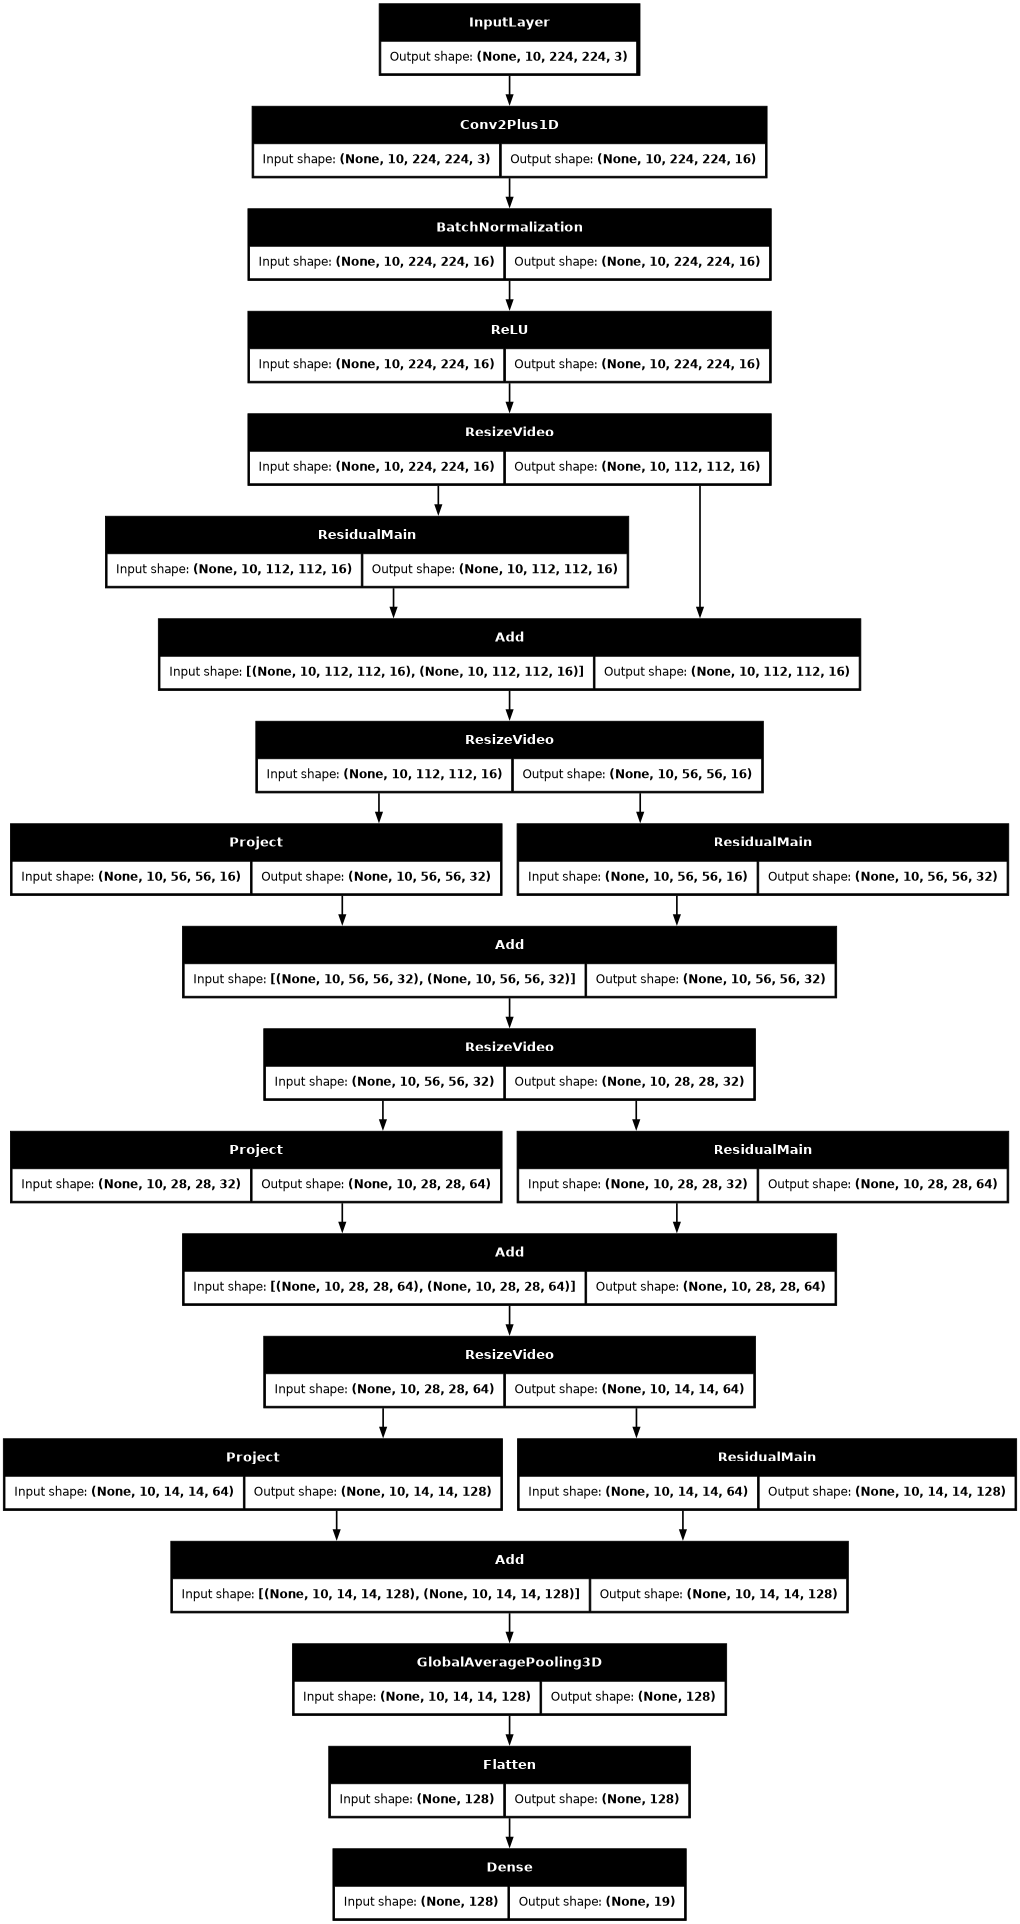

In [27]:
# Visualize the model
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

## Train the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and the `tf.keras.losses.SparseCategoricalCrossentropy` loss function. Use the `metrics` argument to the view the accuracy of the model performance at every step.

In [28]:
import tensorflow as tf
from keras.layers import BatchNormalization
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard

# Create a MirroredStrategy for distributed training
strategy = tf.distribute.MirroredStrategy()

print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

# Open a strategy scope to create and compile the model
with strategy.scope():
    
    input_shape = (None, 10, HEIGHT, WIDTH, 3)
    input = layers.Input(shape=(input_shape[1:]))

    x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(input)
    x = BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

    # Block 1
    x = add_residual_block(x, 16, (3, 3, 3))
    x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

    # Block 2
    x = add_residual_block(x, 32, (3, 3, 3))
    x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

    # Block 3
    x = add_residual_block(x, 64, (3, 3, 3))
    x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

    # Block 4
    x = add_residual_block(x, 128, (3, 3, 3))

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Flatten()(x)
    output = layers.Dense(19, activation='softmax')(x)

    model = keras.Model(input, output)
    # Define and compile your model here  # Your model definition here
    frames, label = next(iter(train_ds))
    model.build(frames)
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Create a ModelCheckpoint callback
    checkpoint_path = "/kaggle/working/training_checkpoints2/cp-{epoch:04d}.weights.h5"  # Path and format
    checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_path,
        verbose=1,
        save_weights_only=True,
        save_freq='epoch',  # Save every epoch
    )

    # Create a ReduceLROnPlateau callback with min_lr
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=10,
        min_lr=1e-7  # Set the minimum learning rate
    )

    # Create a TensorBoard callback
    tensorboard_callback = TensorBoard(
        log_dir='./logs',
        histogram_freq=1,
        write_graph=True,
        write_images=True,
    )

    # Create an EarlyStopping callback
    early_stopping_callback = EarlyStopping(
        monitor='val_loss',
        patience=20,  # Number of epochs with no improvement after which training will be stopped
        verbose=1,
        restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
    )

    # Include the callbacks when training the model
    history = model.fit(
        x=train_ds,
        epochs=1500,
        validation_data=val_ds,
        callbacks=[reduce_lr, tensorboard_callback, early_stopping_callback, checkpoint_callback]
    )


Number of devices: 2
Epoch 1/1500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.0495 - loss: 3.8099
Epoch 1: saving model to /kaggle/working/training_checkpoints2/cp-0001.weights.h5
95/95 ━━━━━━━━━━━━━━━━━━━━ 88s 469ms/step - accuracy: 0.0495 - loss: 3.8061 - val_accuracy: 0.0632 - val_loss: 3.0120 - learning_rate: 0.0010
Epoch 2/1500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.0755 - loss: 3.0227
Epoch 2: saving model to /kaggle/working/training_checkpoints2/cp-0002.weights.h5
95/95 ━━━━━━━━━━━━━━━━━━━━ 41s 435ms/step - accuracy: 0.0757 - loss: 3.0225 - val_accuracy: 0.1263 - val_loss: 2.9997 - learning_rate: 0.0010
Epoch 3/1500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.0689 - loss: 2.9529
Epoch 3: saving model to /kaggle/working/training_checkpoints2/cp-0003.weights.h5
95/95 ━━━━━━━━━━━━━━━━━━━━ 42s 437ms/step - accuracy: 0.0690 - loss: 2.9527 - val_accuracy: 0.1053 - val_loss: 2.9644 - learning_rate: 0.0010
Epoch 4/1500
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [29]:
model.evaluate(test_ds, return_dict=True)

12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 235ms/step - accuracy: 0.1977 - loss: 2.4503


{'accuracy': 0.17894737422466278, 'loss': 2.499589681625366}

To visualize model performance further, use a [confusion matrix](https://www.tensorflow.org/api_docs/python/tf/math/confusion_matrix). The confusion matrix allows you to assess the performance of the classification model beyond accuracy. In order to build the confusion matrix for this multi-class classification problem, get the actual values in the test set and the predicted values.

## Next steps

To learn more about working with video data in TensorFlow, check out the following tutorials:

* [Load video data](https://www.tensorflow.org/tutorials/load_data/video)
* [MoViNet for streaming action recognition](https://www.tensorflow.org/hub/tutorials/movinet)
* [Transfer learning for video classification with MoViNet](https://www.tensorflow.org/tutorials/video/transfer_learning_with_movinet)